In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

In [ ]:
import os
from os.path import join, dirname
from dotenv import load_dotenv
dotenv_path = join(dirname(__file__), '.env')
load_dotenv(dotenv_path)

username = os.environ.get("USERNAME")
password = os.environ.get("PASSWORD")

In [2]:

# Define the connection parameters
server = '80.70.181.166'  # Replace with your server name
database = 'DM_SAP_SD'  # Your database name
username = username   # Your username
password = password   # Your password

# Create a connection string
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

In [3]:
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()
print([x[2] for x in cursor.tables(tableType='TABLE')])
conn.close()

['DIM_CALENDAR', 'DIM_COMPANY', 'DIM_COUNTRY', 'DIM_CURRENCY', 'DIM_CURRENCY_RATES', 'DIM_CUSTOMER', 'DIM_FACTORY', 'DIM_ITEM', 'DIM_OBJECTS', 'DIM_PERSONAL_GROUP', 'DIM_REPRESENTATIVE', 'DIM_SALES_ORGANISATION', 'FACT_110_ORDER_BALANCE', 'FACT_114_INCOMING_ORDERS_DELIVERY_SCHEDULE', 'FACT_115_INCOMING_ORDERS', 'FACT_115_INCOMING_ORDERS_STAGING', 'FACT_116_OFFERINGS', 'FACT_118_ORDERS', 'FACT_120_DELIVERY', 'FACT_120_DELIVERY_STAGING', 'FACT_130_OUTGOING_INVOICE', 'FACT_130_OUTGOING_INVOICE_ACT', 'FACT_130_OUTGOING_INVOICE_STAGING', 'FCC_OUTGOING_INVOICE', 'PL_130_OUTGOING_INVOICE', 'WK_RUNTIME_DEFINITION', 'trace_xe_action_map', 'trace_xe_event_map']


In [4]:
conn = pyodbc.connect(connection_string)

In [5]:
# Create a cursor object
cursor = conn.cursor()

table_names = [x[2] for x in cursor.tables(tableType='TABLE')]

table_names.remove("trace_xe_action_map")
table_names.remove("trace_xe_event_map")

dfs = {}

for table in table_names:
    query = f'SELECT * FROM {table}'
    cursor.execute(query)
    columns = [column[0] for column in cursor.description]
    rows = cursor.fetchall()
    transformed_rows = []
    for row in rows:
        transformed_rows.append(list(row))
    dfs[table] = pd.DataFrame(transformed_rows, columns=columns)

conn.close()

In [6]:
# for table in table_names:
#     dfs[table].describe(include="all").to_excel(f"statistics/{table}.xlsx")

In [7]:
invoice = dfs["FACT_130_OUTGOING_INVOICE"]
items = dfs["DIM_ITEM"]

In [8]:
invoice["item_id"] = invoice["OINV_ITEM_ID"]
items["item_id"] = items["SL_ITEM_ID"]

In [9]:
all_item_ids_match = invoice['item_id'].isin(items['item_id'])
missing_item_ids_orders = invoice[~all_item_ids_match]

In [10]:
print("Orders with item_ids not found in items dataframe:")
print(missing_item_ids_orders["item_id"])

Orders with item_ids not found in items dataframe:
6440    1000_1000__TM2_FREIGHT MANAG.ITEM
6441    1000_1000__TM2_FREIGHT MANAG.ITEM
Name: item_id, dtype: object


In [11]:
merged = pd.merge(invoice, items, on="item_id"); merged

,OINV_SYSID,OINV_COMPANY_NO,OINV_BR_ID,OINV_BR_NO,OINV_INVOICE_ID,OINV_INVOICE_NO,OINV_INVOICE_ITEM_NO,OINV_INVOICE_SUBITEM_NO,OINV_INVOICE_DATE,OINV_PERIOD,...,SL_DELIVERY_FACTORY_NO,SL_DELIVERY_FACTORY_TEXT,SL_STATISTIC_MATERIAL_GROUP_NO,SL_STATISTIC_MATERIAL_GROUP_TEXT,SL_BONUS_GROUP_NO,SL_BONUS_GROUP_TEXT,SL_COMISSION_GROUP_NO,SL_COMISSION_GROUP_TEXT,SL_ORIGIN_COUNTRY_NO,SL_ORIGIN_COUNTRY_TEXT
0,38097,1000,1000_1000,1000,1000_1000_0090018105_10_0,90018105,10,0,1999-12-31,199912,...,,None,2,None,,None,,None,,None
1,38098,1000,1000_1000,1000,1000_1000_0090018106_10_0,90018106,10,0,1999-12-31,199912,...,,None,2,None,,None,,None,,None
2,38099,1000,1000_1000,1000,1000_1000_0090018107_10_0,90018107,10,0,1999-12-31,199912,...,,None,2,None,,None,,None,,None
3,38100,1000,1000_1000,1000,1000_1000_0090018108_10_0,90018108,10,0,1999-12-31,199912,...,1200,None,1,None,,None,,None,,None
4,38101,1000,1000_1000,1000,1000_1000_0090018326_10_0,90018326,10,0,2000-01-17,200001,...,1200,None,1,None,,None,,None,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7170,45269,1000,1000_1000,1000,1000_1000_0090039355_10_0,90039355,10,0,2001-03-31,200103,...,1000,None,1,None,,None,,None,ES,None
7171,45270,1000,1000_1000,1000,1000_1000_0090039355_40_0,90039355,40,0,2001-03-31,200103,...,1000,None,1,None,,None,,None,ES,None
7172,45271,1000,1000_1000,1000,1000_1000_0090039355_50_0,90039355,50,0,2001-03-31,200103,...,1000,None,2,None,,None,,None,,None
7173,45272,1000,1000_1000,1000,1000_1000_0090039356_10_0,90039356,10,0,2002-12-04,200212,...,1200,None,1,None,02,None,,None,DE,None


In [12]:
set(merged["SL_DISTCHA_TEXT"])

{'Direktverkauf',
 'Endkundenverkauf',
 'Service',
 'Werksverkauf',
 'Wiederverkäufer'}

In [13]:
final_customer_merged = merged[merged["SL_DISTCHA_TEXT"] == "Endkundenverkauf"]; final_customer_merged

,OINV_SYSID,OINV_COMPANY_NO,OINV_BR_ID,OINV_BR_NO,OINV_INVOICE_ID,OINV_INVOICE_NO,OINV_INVOICE_ITEM_NO,OINV_INVOICE_SUBITEM_NO,OINV_INVOICE_DATE,OINV_PERIOD,...,SL_DELIVERY_FACTORY_NO,SL_DELIVERY_FACTORY_TEXT,SL_STATISTIC_MATERIAL_GROUP_NO,SL_STATISTIC_MATERIAL_GROUP_TEXT,SL_BONUS_GROUP_NO,SL_BONUS_GROUP_TEXT,SL_COMISSION_GROUP_NO,SL_COMISSION_GROUP_TEXT,SL_ORIGIN_COUNTRY_NO,SL_ORIGIN_COUNTRY_TEXT
0,38097,1000,1000_1000,1000,1000_1000_0090018105_10_0,90018105,10,0,1999-12-31,199912,...,,None,2,None,,None,,None,,None
1,38098,1000,1000_1000,1000,1000_1000_0090018106_10_0,90018106,10,0,1999-12-31,199912,...,,None,2,None,,None,,None,,None
2,38099,1000,1000_1000,1000,1000_1000_0090018107_10_0,90018107,10,0,1999-12-31,199912,...,,None,2,None,,None,,None,,None
4,38101,1000,1000_1000,1000,1000_1000_0090018326_10_0,90018326,10,0,2000-01-17,200001,...,1200,None,1,None,,None,,None,,None
8,38105,1000,1000_1000,1000,1000_1000_0090018327_10_0,90018327,10,0,2000-01-17,200001,...,1200,None,1,None,,None,,None,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7170,45269,1000,1000_1000,1000,1000_1000_0090039355_10_0,90039355,10,0,2001-03-31,200103,...,1000,None,1,None,,None,,None,ES,None
7171,45270,1000,1000_1000,1000,1000_1000_0090039355_40_0,90039355,40,0,2001-03-31,200103,...,1000,None,1,None,,None,,None,ES,None
7172,45271,1000,1000_1000,1000,1000_1000_0090039355_50_0,90039355,50,0,2001-03-31,200103,...,1000,None,2,None,,None,,None,,None
7173,45272,1000,1000_1000,1000,1000_1000_0090039356_10_0,90039356,10,0,2002-12-04,200212,...,1200,None,1,None,02,None,,None,DE,None


In [14]:
hite_and_final = final_customer_merged[final_customer_merged["OINV_SECTOR_NO"] == "HITE"]; hite_and_final

,OINV_SYSID,OINV_COMPANY_NO,OINV_BR_ID,OINV_BR_NO,OINV_INVOICE_ID,OINV_INVOICE_NO,OINV_INVOICE_ITEM_NO,OINV_INVOICE_SUBITEM_NO,OINV_INVOICE_DATE,OINV_PERIOD,...,SL_DELIVERY_FACTORY_NO,SL_DELIVERY_FACTORY_TEXT,SL_STATISTIC_MATERIAL_GROUP_NO,SL_STATISTIC_MATERIAL_GROUP_TEXT,SL_BONUS_GROUP_NO,SL_BONUS_GROUP_TEXT,SL_COMISSION_GROUP_NO,SL_COMISSION_GROUP_TEXT,SL_ORIGIN_COUNTRY_NO,SL_ORIGIN_COUNTRY_TEXT
2,38099,1000,1000_1000,1000,1000_1000_0090018107_10_0,90018107,10,0,1999-12-31,199912,...,,None,2,None,,None,,None,,None
4,38101,1000,1000_1000,1000,1000_1000_0090018326_10_0,90018326,10,0,2000-01-17,200001,...,1200,None,1,None,,None,,None,,None
8,38105,1000,1000_1000,1000,1000_1000_0090018327_10_0,90018327,10,0,2000-01-17,200001,...,1200,None,1,None,,None,,None,,None
9,38106,1000,1000_1000,1000,1000_1000_0090018327_20_0,90018327,20,0,2000-01-17,200001,...,1200,None,1,None,,None,,None,,None
13,38110,1000,1000_1000,1000,1000_1000_0090018328_20_0,90018328,20,0,2000-01-17,200001,...,1200,None,1,None,,None,,None,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,44090,1000,1000_1000,1000,1000_1000_0090035991_40_0,90035991,40,0,2005-11-16,200511,...,1200,None,1,None,02,None,,None,,None
6005,44102,1000,1000_1000,1000,1000_1000_0090036007_10_0,90036007,10,0,2005-11-24,200511,...,1200,None,1,None,02,None,,None,,None
6006,44103,1000,1000_1000,1000,1000_1000_0090036008_10_0,90036008,10,0,2005-11-24,200511,...,1200,None,1,None,02,None,,None,,None
6009,44106,1000,1000_1000,1000,1000_1000_0090036012_10_0,90036012,10,0,2005-12-23,200512,...,1200,None,1,None,02,None,,None,,None


In [15]:
# Convert the date column to datetime format
hite_and_final['date'] = pd.to_datetime(hite_and_final['OINV_INVOICE_DATE'], format='%d.%m.%Y')

# Extract month and year and create a new column for aggregation
hite_and_final['month_year'] = hite_and_final['date'].dt.to_period('D')


C:\Users\valentin grimm\AppData\Local\Temp\4\ipykernel_40768\4067816146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hite_and_final['date'] = pd.to_datetime(hite_and_final['OINV_INVOICE_DATE'], format='%d.%m.%Y')
C:\Users\valentin grimm\AppData\Local\Temp\4\ipykernel_40768\4067816146.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hite_and_final['month_year'] = hite_and_final['date'].dt.to_period('D')


In [16]:
hite_and_final['month_year']

2       1999-12-31
4       2000-01-17
8       2000-01-17
9       2000-01-17
13      2000-01-17
           ...    
5993    2005-11-16
6005    2005-11-24
6006    2005-11-24
6009    2005-12-23
6010    2005-12-23
Name: month_year, Length: 1218, dtype: period[D]

In [17]:
# cutoff corrupt data
hite_and_final = hite_and_final[hite_and_final["month_year"] < "2005-12-31"]

In [18]:
prod_groups = set(hite_and_final["SL_PROD_GR_NO"])

In [19]:
articles = set(hite_and_final["SL_ITEM_TEXT"])

In [20]:
hite_and_final

,OINV_SYSID,OINV_COMPANY_NO,OINV_BR_ID,OINV_BR_NO,OINV_INVOICE_ID,OINV_INVOICE_NO,OINV_INVOICE_ITEM_NO,OINV_INVOICE_SUBITEM_NO,OINV_INVOICE_DATE,OINV_PERIOD,...,SL_STATISTIC_MATERIAL_GROUP_NO,SL_STATISTIC_MATERIAL_GROUP_TEXT,SL_BONUS_GROUP_NO,SL_BONUS_GROUP_TEXT,SL_COMISSION_GROUP_NO,SL_COMISSION_GROUP_TEXT,SL_ORIGIN_COUNTRY_NO,SL_ORIGIN_COUNTRY_TEXT,date,month_year
2,38099,1000,1000_1000,1000,1000_1000_0090018107_10_0,90018107,10,0,1999-12-31,199912,...,2,None,,None,,None,,None,1999-12-31,1999-12-31
4,38101,1000,1000_1000,1000,1000_1000_0090018326_10_0,90018326,10,0,2000-01-17,200001,...,1,None,,None,,None,,None,2000-01-17,2000-01-17
8,38105,1000,1000_1000,1000,1000_1000_0090018327_10_0,90018327,10,0,2000-01-17,200001,...,1,None,,None,,None,,None,2000-01-17,2000-01-17
9,38106,1000,1000_1000,1000,1000_1000_0090018327_20_0,90018327,20,0,2000-01-17,200001,...,1,None,,None,,None,,None,2000-01-17,2000-01-17
13,38110,1000,1000_1000,1000,1000_1000_0090018328_20_0,90018328,20,0,2000-01-17,200001,...,1,None,,None,,None,,None,2000-01-17,2000-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,44090,1000,1000_1000,1000,1000_1000_0090035991_40_0,90035991,40,0,2005-11-16,200511,...,1,None,02,None,,None,,None,2005-11-16,2005-11-16
6005,44102,1000,1000_1000,1000,1000_1000_0090036007_10_0,90036007,10,0,2005-11-24,200511,...,1,None,02,None,,None,,None,2005-11-24,2005-11-24
6006,44103,1000,1000_1000,1000,1000_1000_0090036008_10_0,90036008,10,0,2005-11-24,200511,...,1,None,02,None,,None,,None,2005-11-24,2005-11-24
6009,44106,1000,1000_1000,1000,1000_1000_0090036012_10_0,90036012,10,0,2005-12-23,200512,...,1,None,02,None,,None,,None,2005-12-23,2005-12-23


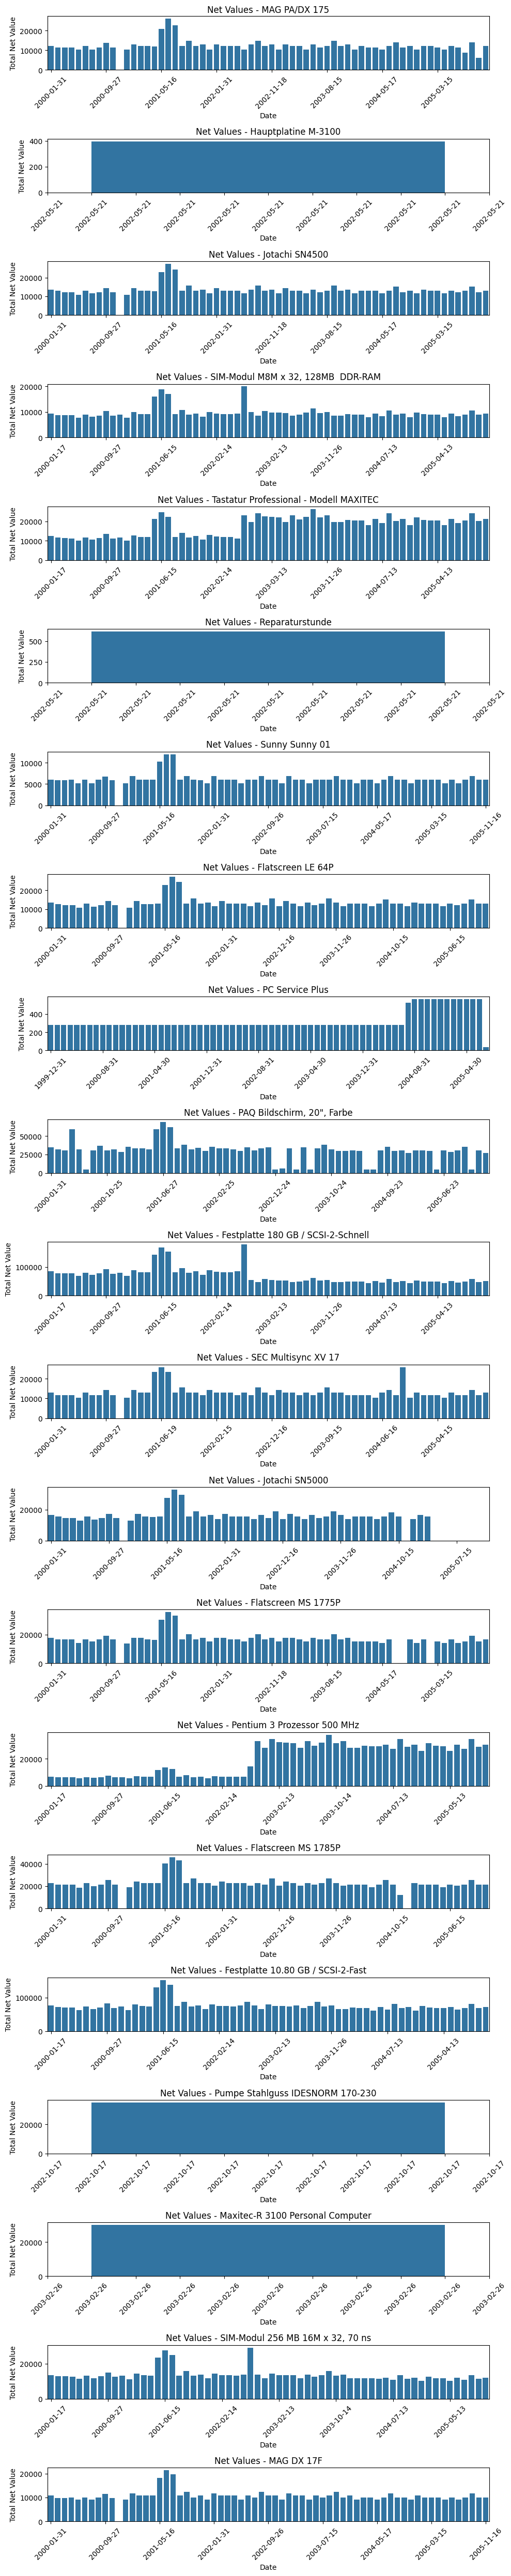

In [21]:
article_dfs = {}
# Create the figure and the subplots
fig, axs = plt.subplots(len(articles), 1, figsize=(10, 50))

for i, group in enumerate(articles):
    group_data = hite_and_final[hite_and_final["SL_ITEM_TEXT"] == group]
    group_data_aggr = group_data.groupby('month_year')[['OINV_INVOICE_NET_VALUE', 'OINV_INVOICE_QUANTITY']].sum().reset_index()
    article_dfs[group] = group_data_aggr
    # Plot the first bar chart for net value
    sns.barplot(ax=axs[i], x='month_year', y='OINV_INVOICE_NET_VALUE', data=group_data_aggr)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Total Net Value')
    axs[i].set_title(f'Net Values - {group}')
    axs[i].tick_params(axis='x', rotation=45)

    # Use MaxNLocator to reduce the number of x-ticks to 10
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=10))


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
filled_articles = {}
for article in articles:
    df = article_dfs[article]

    df['date'] = df['month_year']
    
    # Convert 'date' column to datetime
    # df['date'] = pd.to_datetime(df['date'])

    # Set the date column as the index
    df.set_index('date', inplace=True)
    # Ensure index is in Timestamp format
    df.index = df.index.to_timestamp()

    # Create a date range from the first to the last date in the data
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

    # Reindex the DataFrame to include all dates in the range, filling missing values with zeros
    df_full = df.reindex(full_date_range)

    df_full.fillna(0, inplace=True)
    df_full.index.name = 'date'

    # Optionally reset the index to make the date column a regular column again
    df_full.reset_index(inplace=True)

    filled_articles[article] = df_full

C:\Users\valentin grimm\AppData\Local\Temp\4\ipykernel_40768\2087602787.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with period[D], please explicitly cast to a compatible dtype first.
  df_full.fillna(0, inplace=True)
C:\Users\valentin grimm\AppData\Local\Temp\4\ipykernel_40768\2087602787.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with period[D], please explicitly cast to a compatible dtype first.
  df_full.fillna(0, inplace=True)
C:\Users\valentin grimm\AppData\Local\Temp\4\ipykernel_40768\2087602787.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with period[D], please explicitly cast to a compatible dtype first.
  df_full.fillna(0, inplac

In [23]:
filled_articles["Flatscreen LE 64P"]

,date,month_year,OINV_INVOICE_NET_VALUE,OINV_INVOICE_QUANTITY
0,2000-01-31,2000-01-31,13619.74,19.000
1,2000-02-01,0,0,0
2,2000-02-02,0,0,0
3,2000-02-03,0,0,0
4,2000-02-04,0,0,0
...,...,...,...,...
2112,2005-11-12,0,0,0
2113,2005-11-13,0,0,0
2114,2005-11-14,0,0,0
2115,2005-11-15,0,0,0


MAG PA/DX 175
Hauptplatine M-3100
Jotachi SN4500
SIM-Modul M8M x 32, 128MB  DDR-RAM
Tastatur Professional - Modell MAXITEC
Reparaturstunde
Sunny Sunny 01
Flatscreen LE 64P
PC Service Plus
PAQ Bildschirm, 20", Farbe
Festplatte 180 GB / SCSI-2-Schnell
SEC Multisync XV 17
Jotachi SN5000
Flatscreen MS 1775P
Pentium 3 Prozessor 500 MHz
Flatscreen MS 1785P
Festplatte 10.80 GB / SCSI-2-Fast
Pumpe Stahlguss IDESNORM 170-230
Maxitec-R 3100 Personal Computer
SIM-Modul 256 MB 16M x 32, 70 ns
MAG DX 17F


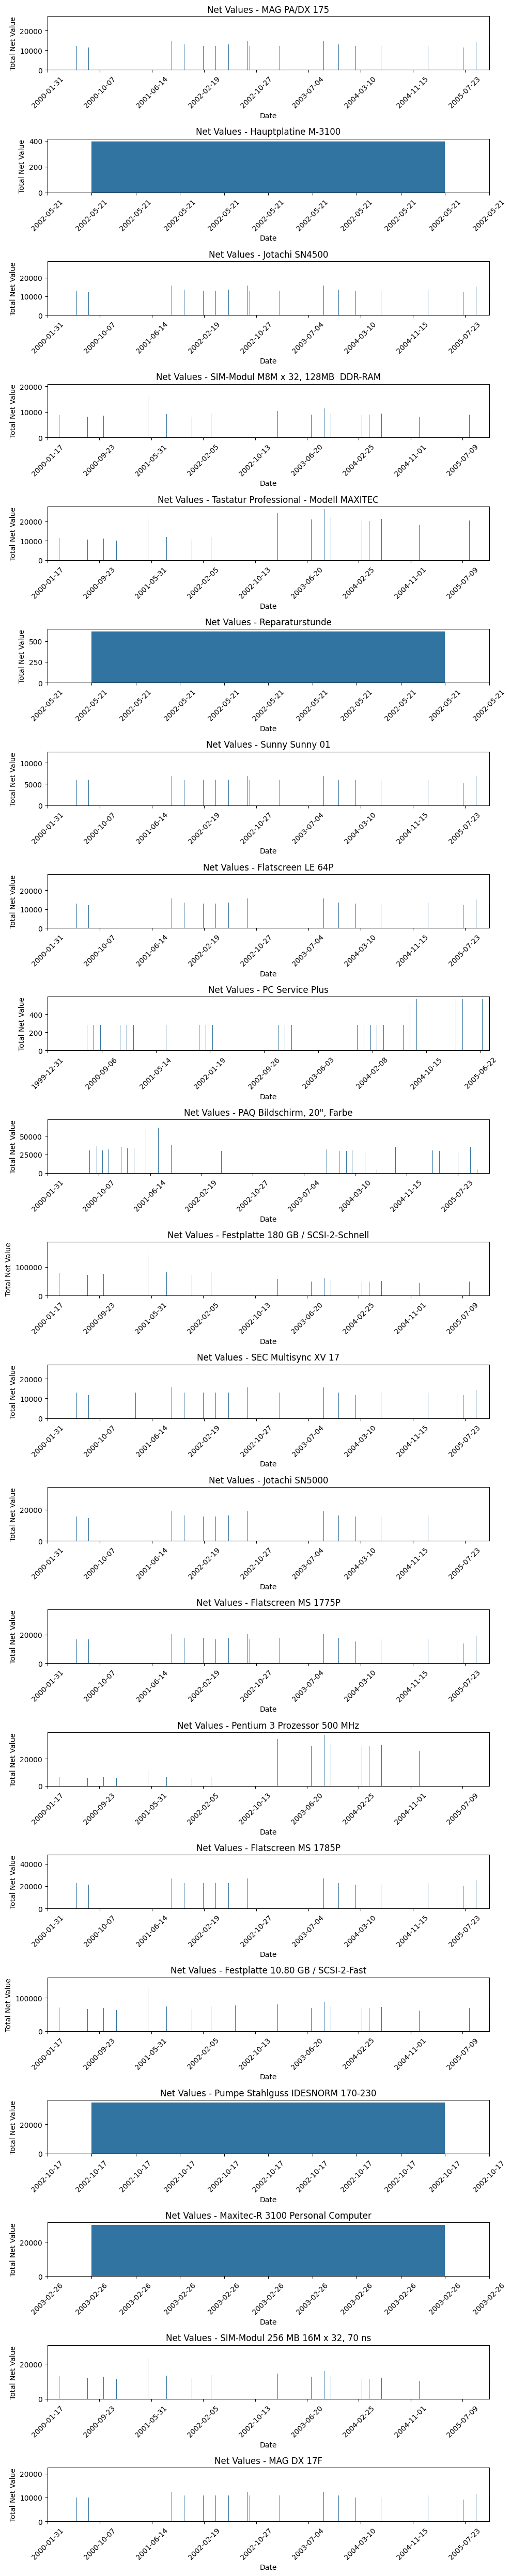

In [24]:
# Create the figure and the subplots
fig, axs = plt.subplots(len(articles), 1, figsize=(10, 50))

count = 0

for key in filled_articles:
    print(key)
    group_data_aggr = filled_articles[key]
    # Plot the first bar chart for net value
    sns.barplot(ax=axs[count], x='date', y='OINV_INVOICE_NET_VALUE', data=group_data_aggr)
    axs[count].set_xlabel('Date')
    axs[count].set_ylabel('Total Net Value')
    axs[count].set_title(f'Net Values - {key}')
    axs[count].tick_params(axis='x', rotation=45)

    # Use MaxNLocator to reduce the number of x-ticks to 10
    axs[count].xaxis.set_major_locator(MaxNLocator(nbins=10))
    count += 1


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
from statsmodels.tsa.seasonal import STL

In [26]:
df = filled_articles["Flatscreen MS 1775P"]
df["date"] = pd.to_datetime(df["date"])
# Set 'date' column as index
df.set_index('date', inplace=True)

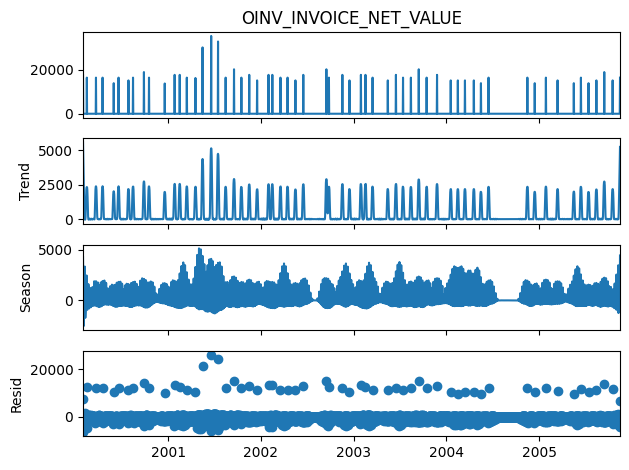

In [27]:
# Apply STL decomposition
stl = STL(df['OINV_INVOICE_NET_VALUE'], seasonal=13)  # seasonal=13 for weekly seasonality if data is daily
result = stl.fit()

# Plot the decomposed components
result.plot()
plt.show()

In [29]:
df["sales"] = pd.to_numeric(df['OINV_INVOICE_NET_VALUE'])

In [30]:
result.trend

date
2000-01-31    5602.372047
2000-02-01    4515.831739
2000-02-02    3469.772794
2000-02-03    2448.103563
2000-02-04    1458.381565
                 ...     
2005-11-12    1374.184391
2005-11-13    2299.902591
2005-11-14    3251.595338
2005-11-15    4230.910068
2005-11-16    5260.360740
Name: trend, Length: 2117, dtype: float64

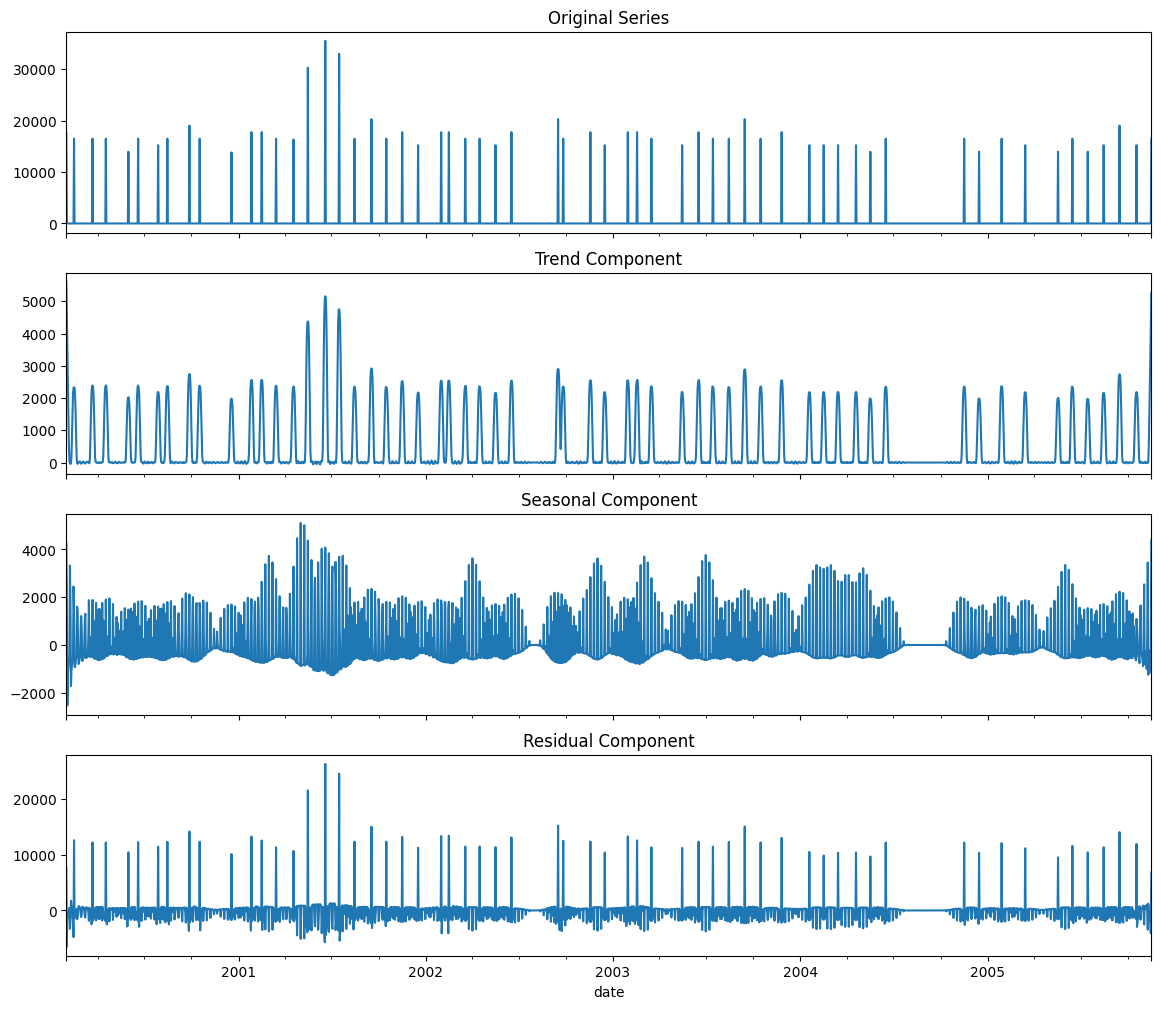

In [31]:
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot each component separately
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
df['sales'].plot(ax=axes[0], title='Original Series')
trend.plot(ax=axes[1], title='Trend Component')
seasonal.plot(ax=axes[2], title='Seasonal Component')
residual.plot(ax=axes[3], title='Residual Component')
plt.show()

In [32]:
df.head()

,month_year,OINV_INVOICE_NET_VALUE,OINV_INVOICE_QUANTITY,sales
date,,,,
2000-01-31,2000-01-31,17560.29,14.000,17560.29
2000-02-01,0,0,0,0.00
2000-02-02,0,0,0,0.00
2000-02-03,0,0,0,0.00
2000-02-04,0,0,0,0.00


In [33]:

for key in article_dfs:
    df = article_dfs[key]
    df["net_sales"] = df["OINV_INVOICE_NET_VALUE"].astype("float")
    df["quantity"] = df["OINV_INVOICE_QUANTITY"].astype("int64")
    df = df.drop(["OINV_INVOICE_NET_VALUE", "OINV_INVOICE_QUANTITY", "month_year"], axis=1)
    print(df.dtypes)
    filename = key.replace(" ", "").replace(".", "").replace("/", "_").replace(",", "_").replace("\"", "zoll")
    print(filename)
    df.to_csv(f"./hite_items/{filename}.csv")

net_sales    float64
quantity       int64
dtype: object
MAGPA_DX175
net_sales    float64
quantity       int64
dtype: object
HauptplatineM-3100
net_sales    float64
quantity       int64
dtype: object
JotachiSN4500
net_sales    float64
quantity       int64
dtype: object
SIM-ModulM8Mx32_128MBDDR-RAM
net_sales    float64
quantity       int64
dtype: object
TastaturProfessional-ModellMAXITEC
net_sales    float64
quantity       int64
dtype: object
Reparaturstunde
net_sales    float64
quantity       int64
dtype: object
SunnySunny01
net_sales    float64
quantity       int64
dtype: object
FlatscreenLE64P
net_sales    float64
quantity       int64
dtype: object
PCServicePlus
net_sales    float64
quantity       int64
dtype: object
PAQBildschirm_20zoll_Farbe
net_sales    float64
quantity       int64
dtype: object
Festplatte180GB_SCSI-2-Schnell
net_sales    float64
quantity       int64
dtype: object
SECMultisyncXV17
net_sales    float64
quantity       int64
dtype: object
JotachiSN5000
net_sales    fl